In [ ]:
import pandas as pd

df_personal = pd.read_excel("/content/cleaned_personal_details.xlsx")
df_price = pd.read_excel("/content/cleaned_price_data.xlsx")

print(df_personal.head())
print(df_price.head())

  policy_no.  children smoker     region
0  PLC157006         0     no  southwest
1  PLC157033         1     no  southwest
2  PLC157060         0     no  southwest
3  PLC157087         1     no  southwest
4  PLC157186         5     no  southwest
  policy_no.  age     sex     bmi      charges
0  PLC156898   19  female  27.900  16884.92400
1  PLC156907   18    male  33.770   1725.55230
2  PLC156916   28    male  33.000   4449.46200
3  PLC156925   33    male  22.705  21984.47061
4  PLC156934   32    male  28.880   3866.85520


In [ ]:
print("Personal Columns:", df_personal.columns)
print("Price Columns:", df_price.columns)


Personal Columns: Index(['policy_no.', 'children', 'smoker', 'region'], dtype='object')
Price Columns: Index(['policy_no.', 'age', 'sex', 'bmi', 'charges'], dtype='object')


In [ ]:
df = pd.merge(df_personal, df_price, on="policy_no.", how="inner")

df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   policy_no.  1338 non-null   object 
 1   children    1338 non-null   int64  
 2   smoker      1338 non-null   object 
 3   region      1338 non-null   object 
 4   age         1338 non-null   int64  
 5   sex         1338 non-null   object 
 6   bmi         1338 non-null   float64
 7   charges     1338 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


policy_no.    0
children      0
smoker        0
region        0
age           0
sex           0
bmi           0
charges       0
dtype: int64

In [ ]:
df.groupby("sex")["charges"].mean() #gender impact


sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

In [ ]:
df["charges"].mean() #avg money spent

np.float64(13270.422265141257)

In [ ]:
df.groupby("region")["charges"].mean()  #Location Impact


region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

In [ ]:
df.groupby("children")["charges"].mean() #Dependents (Children) Impact


children
0    12365.975602
1    12731.171832
2    15073.563734
3    15355.318367
4    13850.656311
5     8786.035247
Name: charges, dtype: float64

In [ ]:
df.groupby(pd.cut(df["bmi"], bins=5))["charges"].mean() #BMI Impact


/tmp/ipython-input-1229359432.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["bmi"], bins=5))["charges"].mean() #BMI Impact


bmi
(15.923, 23.394]     9503.486692
(23.394, 30.828]    11554.830480
(30.828, 38.262]    15790.802305
(38.262, 45.696]    15258.426910
(45.696, 53.13]     17289.421583
Name: charges, dtype: float64

In [ ]:
df.groupby("smoker")["charges"].mean() #Smoker Impact


smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

In [ ]:
df.groupby(pd.cut(df["age"], bins=5))["charges"].mean() #are there any age barriers


/tmp/ipython-input-3698108490.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.cut(df["age"], bins=5))["charges"].mean() #are there any age barriers


age
(17.954, 27.2]     9098.192248
(27.2, 36.4]      10991.125921
(36.4, 45.6]      13628.318836
(45.6, 54.8]      15968.998082
(54.8, 64.0]      18513.276227
Name: charges, dtype: float64

In [ ]:
from sklearn.preprocessing import LabelEncoder #encoding catagorical data

le = LabelEncoder()

for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])


In [ ]:
X = df.drop(["charges", "policy_no."], axis=1)
y = df["charges"]


In [ ]:
from sklearn.model_selection import train_test_split #Train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.linear_model import LinearRegression #training three baseline models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

models = {
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(),
    "GradientBoost": GradientBoostingRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(name, "R2 Score:", r2_score(y_test, preds))


Linear R2 Score: 0.7310354872877262
RandomForest R2 Score: 0.8424345785595462
GradientBoost R2 Score: 0.8608555419025341


In [ ]:
import numpy as np  #Picking Best Model + Evaluate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

best_model = RandomForestRegressor()
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("R2:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R2: 0.8431537468148079
RMSE: 4720.956344654289


In [ ]:
from sklearn.model_selection import GridSearchCV #Hyperparameter Tuning

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10, None]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=3)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("Best Params:", grid.best_params_)


Best Params: {'max_depth': 5, 'n_estimators': 100}


In [ ]:
importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_   #Feature Importance
}).sort_values(by="Importance", ascending=False)

importance


Feature  Importance
1    smoker    0.702172
5       bmi    0.168223
3       age    0.115450
0  children    0.010415
2    region    0.003322
4       sex    0.000418

In [ ]:
import joblib
joblib.dump(best_model, "medibuddy_model.pkl") #saving the final model


['medibuddy_model.pkl']

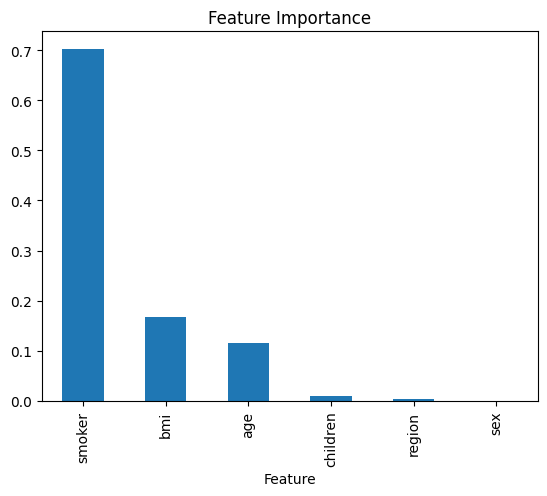

In [ ]:
import matplotlib.pyplot as plt

importance.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Feature Importance")
plt.show()


In [ ]:
import joblib

joblib.dump(best_model, "medibuddy_model.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("FINAL R2 SCORE:", r2)
print("FINAL RMSE:", rmse)


FINAL R2 SCORE: 0.859275678165879
FINAL RMSE: 4471.749760620847


In [ ]:
import joblib
import numpy as np

model = joblib.load("medibuddy_model.pkl")

def predict_charges(children, smoker, region, age, sex, bmi):
    input_data = np.array([[children, smoker, region, age, sex, bmi]])
    prediction = model.predict(input_data)
    return prediction[0]

# Example test
print("Predicted Charges:", predict_charges(2, 1, 3, 45, 1, 27.5))


Predicted Charges: 24730.234471615593


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
